<a href="https://colab.research.google.com/github/shihmujan/classs/blob/main/updata_Alzheimer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

導入資料

In [1]:
import gdown
import zipfile 
import os 

def zip_list(file_path):
    zf = zipfile.ZipFile(file_path, 'r')
    zf.extractall()

url = 'https://drive.google.com/u/2/uc?id=1D0K9yj4FZ4GbDj1xVzJtq5yH11yLO7YR&export=download&confirm=t'
output = "Alzheimer.zip"
gdown.download(url, output)

file_path = "Alzheimer.zip"
zip_list(file_path)

Downloading...
From: https://drive.google.com/u/2/uc?id=1D0K9yj4FZ4GbDj1xVzJtq5yH11yLO7YR&export=download&confirm=t
To: /content/Alzheimer.zip
100%|██████████| 104M/104M [00:01<00:00, 78.7MB/s] 


安裝跟升級

In [1]:
!pip install efficientnet_pytorch
!pip install --upgrade matplotlib

導入安裝包

In [5]:
from trainer import *
from utils_tool import *
import torch
from efficientnet_pytorch import EfficientNet
from skimage.segmentation import mark_boundaries
from transform import *
import torch.optim as optim
import matplotlib.pyplot as plt
from loss_fn import *
import numpy as np
import line
import random
import warnings

warnings.filterwarnings('ignore')

訓練參數

In [6]:
learning_rate = 0.001
batch_size = 80
num_workers = 0
epochs = 300
resume = True
train_path = 'Alzheimer/train/'
test_path = 'Alzheimer/test/'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

取得訓練與測試的Dataloader

In [7]:
train_ds, test_ds, id_to_class = get_dataloader(train_path,test_path,batch_size,num_workers)

建立模型與設定訓練參數。使用train.training()可開始訓練

In [8]:
model = EfficientNet.from_pretrained('efficientnet-b2').to(device)
num_feature = model._fc.in_features
model.fc = nn.Linear(num_feature, 4).to(device)

if resume:
    model = load_checkpoint(model,path='checkpoint/ckpt_0.pth')

#optimizer = optim.SGD(params=model.parameters(),lr=learning_rate, momentum=0.9, nesterov=True)
optimizer = optim.Adam(params = model.parameters(),lr=learning_rate)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.95)
criterion = nn.CrossEntropyLoss()

train = trainer(train_ds, test_ds, model, optimizer, scheduler, criterion, epochs=epochs)
#train.training()

Loaded pretrained weights for efficientnet-b2
==> Resuming from checkpoint..


取得class對應的id

In [22]:
class_to_id = {v: k for k, v in id_to_class.items()}
image_path_id = test_ds_path(test_path, class_to_id)
print(class_to_id)

{'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}


預測準確度

In [23]:
from tqdm import tqdm
from PIL import Image
import cv2
model.eval()
transform = get_test_transforms()
correct = 0
for idx, (img_path, lab) in enumerate(tqdm(image_path_id)):
    image = Image.open(img_path).convert('RGB')
    img = transform(image)[np.newaxis,:,:,:].to(device)
    out = model(img)
    predicted = int(torch.argmax(out, 1))
    if predicted == lab:
        correct += 1
    image_path_id[idx] = [img_path, lab, predicted]
print('\n',correct/len(image_path_id))

100%|██████████| 1279/1279 [00:42<00:00, 30.01it/s]


 0.8811571540265832


預測個別的準確度

In [11]:
total_lab_class = [0,0,0,0]
total_pred_class = [0,0,0,0]
for idx, (img_p, lab, pred) in enumerate(image_path_id):
    total_lab_class[lab] = total_lab_class[lab] + 1
    if lab == pred:
        total_pred_class[pred] = total_pred_class[pred] + 1
accuracy = [p / l for p, l in zip(total_pred_class, total_lab_class)]
print(accuracy)
    
#print('MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3)

[0.8435754189944135, 0.3333333333333333, 0.93125, 0.8392857142857143]


顯示各項資料的正確與錯誤

In [12]:
each_class_pred_info = {0:{0:[],1:[],2:[],3:[]}, 1:{0:[],1:[],2:[],3:[]}, 2:{0:[],1:[],2:[],3:[]}, 3:{0:[],1:[],2:[],3:[]}}
for idx, info in enumerate(image_path_id):
    each_class_pred_info[info[1]][info[2]].append(info)

for k in each_class_pred_info.keys():
    info = each_class_pred_info[k]
    print(id_to_class[k], ' predict as:')
    print()
    total = 0
    for n in info.keys():
        print('%-16s' % id_to_class[n], ':', end='')
        print(len(info[n]),end='')
        if n == k:
            print('  correct!', end='')
        print()
        total += len(info[n])
    print('total:', total, ' Accuracy:', accuracy[k])
    print()

MildDemented  predict as:

MildDemented     :151  correct!
ModerateDemented :0
NonDemented      :13
VeryMildDemented :15
total: 179  Accuracy: 0.8435754189944135

ModerateDemented  predict as:

MildDemented     :5
ModerateDemented :4  correct!
NonDemented      :0
VeryMildDemented :3
total: 12  Accuracy: 0.3333333333333333

NonDemented  predict as:

MildDemented     :11
ModerateDemented :0
NonDemented      :596  correct!
VeryMildDemented :33
total: 640  Accuracy: 0.93125

VeryMildDemented  predict as:

MildDemented     :17
ModerateDemented :0
NonDemented      :55
VeryMildDemented :376  correct!
total: 448  Accuracy: 0.8392857142857143



簡單的定義lime使用與顯示圖片

In [13]:
class line_image():
    def __init__(self,model,transform):
        self.model = model
        self.transform = transform

    def batch_predict(self,images):
        batch = torch.stack(tuple(self.transform(i) for i in images), dim=0)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.model.to(device)
        batch = batch.to(device)

        logits = model(batch)
        probs = F.softmax(logits, dim=1)

        return probs.detach().cpu().numpy()

    def explain_image(self,img):
        explainer = line.LimeImageExplainer()
        exp = explainer.explain_instance(image, self.batch_predict, top_labels=4, hide_color=0, num_samples=500)
        
        return exp

In [14]:
def get_image(class_name, pred_name, dic=class_to_id):
    class_id = class_to_id[class_name]
    pred_id = class_to_id[pred_name]
    data_list = each_class_pred_info[class_id][pred_id]
    if data_list==[]:
        return 'No image' , class_name, pred_name
    image_info = random.choice(data_list)
    image = np.array(Image.open(image_info[0]).convert('RGB'))
    return image, class_name, pred_name

def show_image(trainsets, class_dic=None, lab=None, pred=None, row=4, col=4):
    fig, ax = plt.subplots(nrows=row, ncols=col, sharex='all', sharey='all') # 一张图片有5行5列个子图
    fig.suptitle('Predict\n', fontsize=16, color='red')
    fig.supylabel('Label', fontsize=16, color='red')

    fig.set_figheight(15)
    fig.set_figwidth(15)
    ax = ax.flatten()
    for idx,img in enumerate(trainsets):
        if idx == row * col:
            break
        ax[idx].imshow(img[0])
        if idx in [0,1,2,3]:
            ax[idx].set_title(id_to_class[idx], fontsize=16)
        if idx in [0,4,8,12]:
            ax[idx].set_ylabel(img[1], fontsize=16)
            
        ax[0].set_xticks([])
        ax[0].set_yticks([])

    plt.tight_layout()  # 自动紧凑布局
    plt.show()

get_image(類別的標籤圖片, 圖片預測出的結果)

  0%|          | 0/500 [00:00<?, ?it/s]

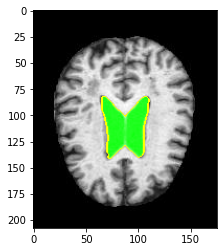

In [15]:
image, class_name, pred_name = get_image('MildDemented', 'MildDemented')

exp = line_image(model, transform)
exp = exp.explain_image(image)
temp, mask = exp.get_image_and_mask(0, positive_only=False, num_features=1, hide_rest=False)
img = mark_boundaries(temp / 255.0, mask)
plt.imshow(img)

  0%|          | 0/500 [00:00<?, ?it/s]

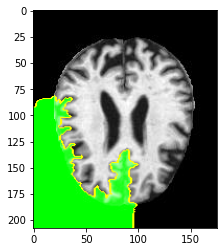

In [16]:
image, class_name, pred_name = get_image('MildDemented', 'MildDemented')

exp = line_image(model, transform)
exp = exp.explain_image(image)
temp, mask = exp.get_image_and_mask(0, positive_only=False, num_features=1, hide_rest=False)
img = mark_boundaries(temp / 255.0, mask)
plt.imshow(img)

計算lime取得4*4影像，並顯示預測類別的最大可能位置

In [17]:
exp = line_image(model, transform)
all_list = []
for l in range(4):
    label_list = []
    for p in range(4):
        image, class_name, pred_name = get_image(id_to_class[l], id_to_class[p])
        if image == 'No image':
            label_list.append([np.zeros((208, 176, 3)),class_name, pred_name])
            continue
        exp = line_image(model, transform)
        exp = exp.explain_image(image)
        temp, mask = exp.get_image_and_mask(class_to_id[pred_name], positive_only=False, num_features=1, hide_rest=False) #修改class_to_id[pred_name]成class_to_id[class_name] 可用於顯示預測標籤最大的可能位置
        img = mark_boundaries(temp / 255.0, mask)
        if l == 1 or p == 1:                        #如果想看ModerateDemented
            img = np.zeros((208, 176, 3))                 #這兩行不要
        label_list.append([img,class_name, pred_name])
    all_list.append(label_list)
all_image = []
for l in range(4):
    for p in range(4):
        all_image.append(all_list[l][p])

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

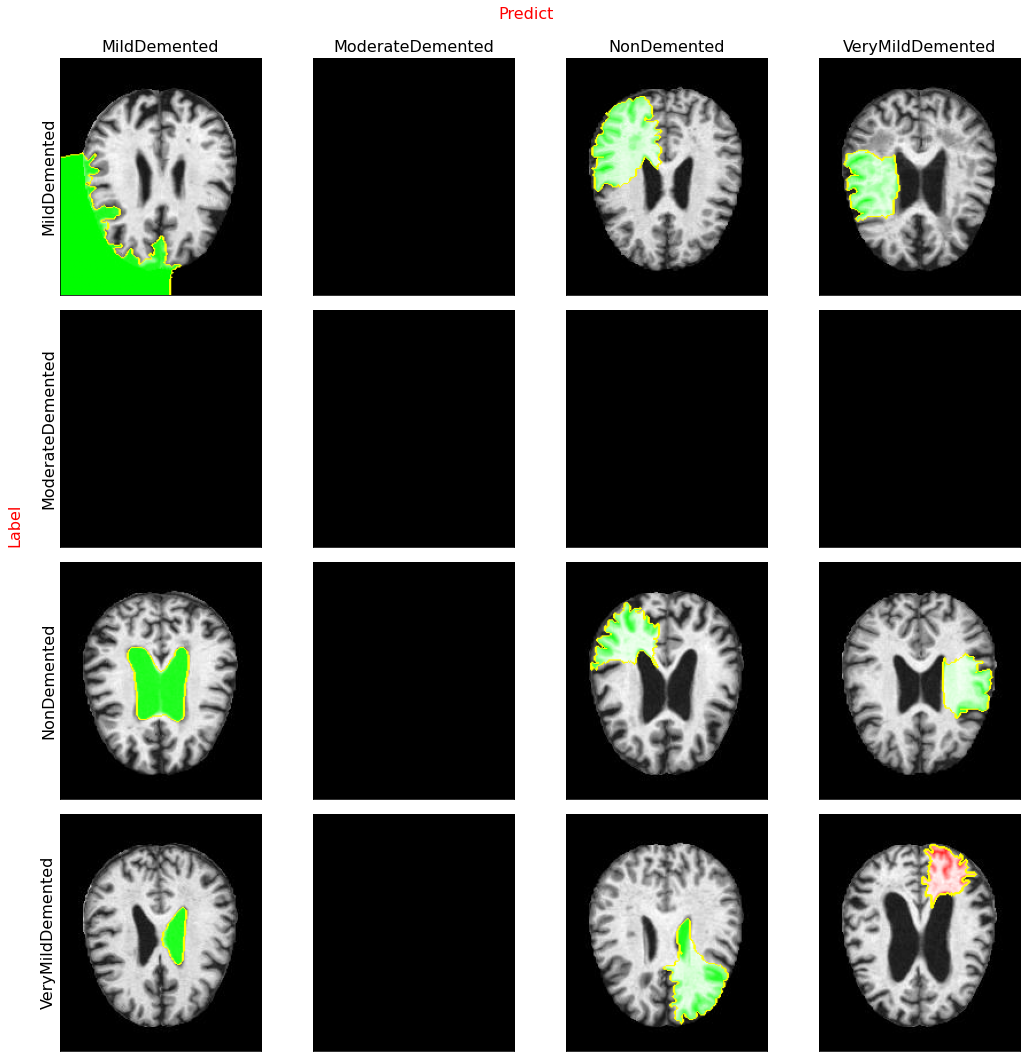

In [18]:
show_image(all_image)

In [19]:
exp = line_image(model, transform)
all_list = []
for l in range(4):
    label_list = []
    for p in range(4):
        image, class_name, pred_name = get_image(id_to_class[l], id_to_class[p])
        if image == 'No image':
            label_list.append([np.zeros((208, 176, 3)),class_name, pred_name])
            continue
        exp = line_image(model, transform)
        exp = exp.explain_image(image)
        temp, mask = exp.get_image_and_mask(class_to_id[class_name], positive_only=False, num_features=1, hide_rest=False)
        img = mark_boundaries(temp / 255.0, mask)
        if l == 1 or p == 1:                       #如果想看ModerateDemented
            img = np.zeros((208, 176, 3))          #這兩行不要
        label_list.append([img,class_name, pred_name])
    all_list.append(label_list)
all_image = []
for l in range(4):
    for p in range(4):
        all_image.append(all_list[l][p])

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

計算lime取得4*4影像，並顯示預測標籤最大的可能位置

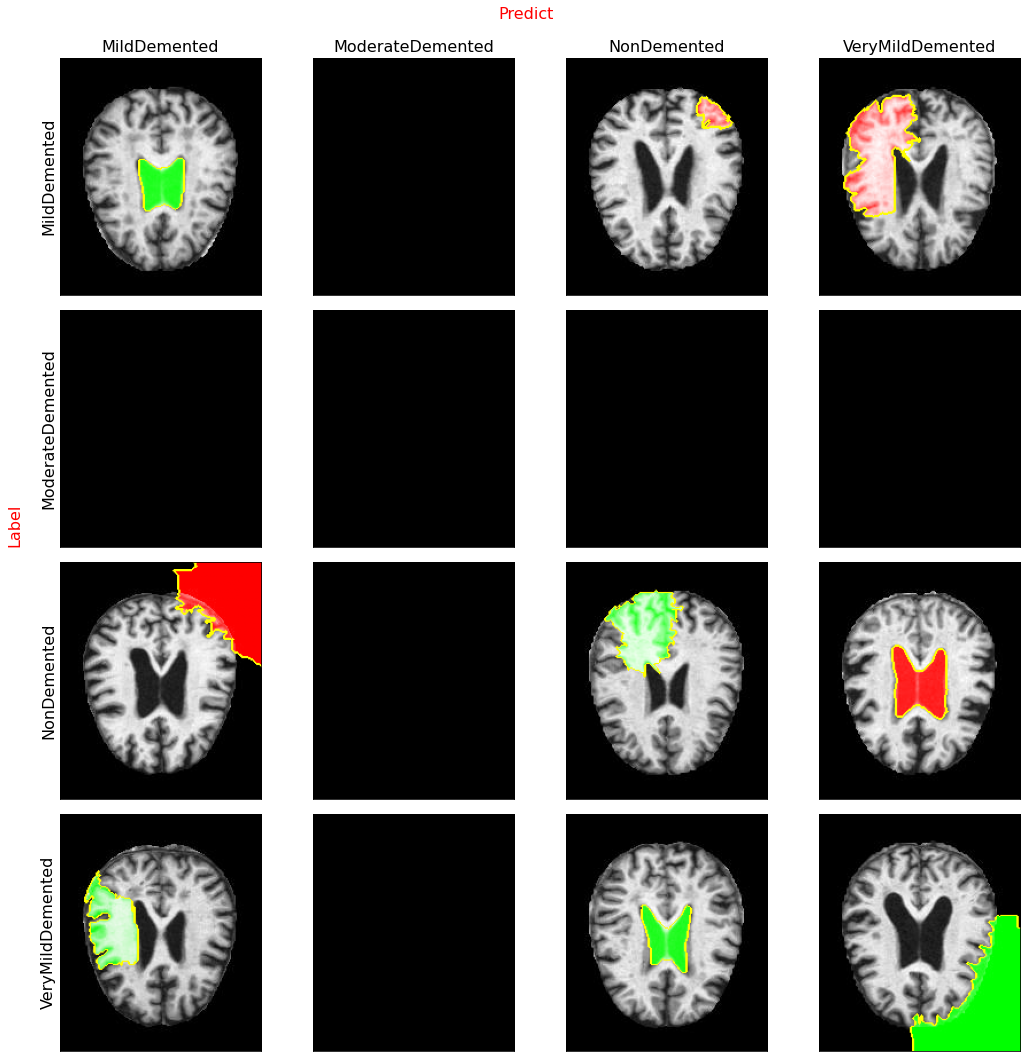

In [20]:
show_image(all_image)